In [1]:
import numpy as np
import bisect as bisect
from scipy import interpolate
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import time
from mpl_toolkits.mplot3d import Axes3D

# FX Forward Pricing Under the Vasicek Model

Given two rate of interest $r_d$ and $r_f$ where $r_d$ and $r_f$ are the domestic and foreign rate of interest. we can price a forward exchange rate contract according to

$$
F^X(0,T) = X_0\frac{B^f(0,T)}{B^d(0,t)}
$$

where $X_0$ is the initial domestic/foreign rate of exchange and, $B^f(0,T)$ and $B^d(0,T)$ are the domestic and foreign zero-coupon bond price at time $T$.

Starting with two independent Ornstein-Uhlenbeck processes to model the stochastic interest rate of the domestic and foreign interest rate;

$$
dr_t^d = \theta^d(\mu^d-r_t^d)dt + \sigma^d dW_t,
$$

$$
dr_t^f = \theta^f(\mu^f-r_t^f)dt + \sigma^f dW_t.
$$

The analytical solution of the SDE is the following;
$$
r_t = r_0e^{-\theta t} + \mu(1-e^{-\theta t}) + \sigma e^{-\theta t} \int_0^t e^{\theta s}dW_s
$$

The initial price of a bond at time $t=0$ that expiries at time $t=T$ is given by the following formula;

$$
B(0,T) = \mathbb{E}\left[e^{\left(-\int_0^Tr_sds\right)}\right].
$$

According to the litterature, we can solve this anatyically via PDE which leads to

$$
B(0,T) = \exp\left\{-A(0,T)r_0 + D(0,T)\right\},
$$

where $r_0$ is the rate of interest at time $t=0$

$$
A(0,T) = \frac{1-e^{-\theta T}}{\theta},
$$

$$
D(0,T) = \left(\mu - \frac{\sigma^2}{2\theta^2}\right)\left[A(0,T)-T\right]-\frac{\sigma^2A(0,T)^2}{4\theta}.
$$

See Journal of Applied Mathematics and Decision Sciences, 8(1), 1-14 or [here](http://www.kurims.kyoto-u.ac.jp/EMIS/journals/HOA/JAMDS/8/11.pdf) for reference.

###### Payoff Pathwise Differential wrt $r_0$:

$$
\frac{\partial}{\partial r_0} exp\Big\{-\int^T_0 r_s ds\Big\}(1) =-\Bigg(\frac{1-e^{-\theta T}}{\theta}\Bigg) exp\Big\{-\int^T_0 r_s ds\Big\}=-A(0,T)exp\Big\{-\int^T_0 r_s ds\Big\}
$$

Given initial conditions and parameters of the stochastic process for both domestic and foreign rate of interest, we can find the analytical solution for both bond prices and the forward exchange rate.

#### Vasicek Model: Bond Price PDE Representation

Given that 
$$
dr_t = \alpha(r_t,t)dt + \beta(r_t,t)dW_t
$$

We have that 

$$
dC_t = \frac{\partial C}{\partial t}dt + \frac{\partial C}{\partial r} dr_t + \frac{1}{2}\frac{\partial^2 C}{\partial r^2}d<r>_t
$$

$$
= \left[ \frac{\partial C}{\partial t} + \alpha \frac{\partial C}{\partial r} + \frac{1}{2}\beta^2\frac{\partial^2 C}{\partial r^2}\right]dt + \beta \frac{\partial C}{\partial r}dW_t
$$

$$
\frac{\partial C}{\partial t} + \alpha(r_t,t)\frac{\partial C}{\partial r} + \frac{1}{2}\beta(r_t,t)^2\frac{\partial^2 C}{\partial r^2} - r_tC_t = 0 
$$

We are now given that $\alpha(r_t,t) = \theta(\mu - r_t)$ and $\beta(r_t,t) = \sigma$, which leads to the following PDE:

$$
\frac{\partial C}{\partial t} + \left[\theta(\mu - r_t) \right]\frac{\partial C}{\partial r} + \frac{\sigma^2}{2}\frac{\partial^2 C}{\partial r^2} - r_tC = 0
$$

Define $\nu = \theta(\mu - r_t)$ and use the central-difference explicit finite difference scheme to the PDE.

$$
\frac{\partial C}{\partial t} + \nu\frac{\partial C}{\partial r} + \frac{\sigma^2}{2}\frac{\partial^2 C}{\partial r^2} - r_tC = 0
$$

## 1. Vasicek Bond: Closed Form Formulas

In [2]:
def stoc_bond_price(dynamics, contract):
    """
    Function that computes the analytical zero-coupon bond price given vasicek interest rate model 
    """
    
    theta, mu, sigma, r0, t = dynamics.theta, dynamics.mu, dynamics.sigma, dynamics.r0, contract.T
    
    A = (1-np.exp(-theta*t))/theta
    D = (mu - (sigma**2)/(2*(theta)**2))*(A-t) - ((sigma**2)*A**2)/(4*theta)
    
    return np.exp(-A*r0+D)


def diff_bond_price(dynamics, contract):
    """
    Function that computes the analytical zero-coupon bond price sensitivity wrt r_0 given vasicek interest rate model 
    """
    
    theta, mu, sigma, r0, T = dynamics.theta, dynamics.mu, dynamics.sigma, dynamics.r0, contract.T
    
    A = (1-np.exp(-theta*T))/theta
    D = (mu - (sigma**2)/(2*(theta)**2))*(A-T) - ((sigma**2)*A**2)/(4*theta)
    
    return -A*np.exp(D-A*r0)


def forward_exchange_rate(X0, dynamics_f, dynamics_d, contract):
    """
    Function that computes the analytical price of a forward exchange rate given the parameters of 2 short rate following ornstein-uhlenbeck SDE 
    """
    
    bond_f = stoc_bond_price(dynamics_f, contract)
    bond_d = stoc_bond_price(dynamics_d, contract)
    
    return X0*bond_f/bond_d

## 2. Parameters: Dynamics, Contract, Finite Differences, Monte-Carlo 

In [3]:
# Initialize values for the Dynamics for debugging purposes

class Dynamics:
    pass

domestics_bond = Dynamics()
domestics_bond.r0 = 0.04
domestics_bond.theta = 3
domestics_bond.mu = 0.05
domestics_bond.sigma = 0.08

foreign_bond = Dynamics()
foreign_bond.r0 = 0.10
foreign_bond.theta = 4
foreign_bond.mu = 0.08
foreign_bond.sigma = 0.12

class Contract:
    pass

contract = Contract()
contract.T = 1 

class FD:
    pass

#Explicit Scheme

fd_dom = FD()
fd_dom.rMax=0.35
fd_dom.rMin=-0.1
fd_dom.deltat=contract.T/10000
fd_dom.deltar=np.min([domestics_bond.sigma**2,0.05])


fd_for = FD()
fd_for.rMax=0.35
fd_for.rMin=-0.1
fd_for.deltat=contract.T/10000
fd_for.deltar=np.min([foreign_bond.sigma**2,0.05])

#CN Scheme
fd_dom2 = FD()
fd_dom2.rMax=0.35
fd_dom2.rMin=-0.1
fd_dom2.deltat=contract.T/10000
fd_dom2.deltar=domestics_bond.sigma*np.sqrt(fd_dom2.deltat) 


fd_for2 = FD()
fd_for2.rMax=0.35
fd_for2.rMin=-0.1
fd_for2.deltat=contract.T/10000
fd_for2.deltar=foreign_bond.sigma*np.sqrt(fd_for2.deltat)



## 3. Vasicek Bond: FD Explicit Scheme & FD Crank-Nicolson Scheme 

In [4]:
def pricer_bond_vasicek_explicitFD(contract,dynamics,fd):
    
    """
    returns array of all initial short rates,
    and the corresponding array of zero-coupon
    T-maturity bond prices
    """ 

    T = contract.T
    theta, mu, sigma = dynamics.theta, dynamics.mu, dynamics.sigma    
    rMax, rMin, deltar, deltat = fd.rMax, fd.rMin, fd.deltar, fd.deltat    
    N=round(T/deltat)
    if abs(N-T/deltat) > 1e-12:
        raise ValueError("Bad delta t")
        
    r=np.arange(rMax,rMin-deltar/2,-deltar)   
    bondprice=np.ones(np.size(r))
    
    v = theta*(mu-r)
    
    qu=    0.5*((sigma**2*deltat)/(deltar**2)+(v*deltat)/(deltar))
    qd=    0.5*((sigma**2*deltat)/(deltar**2)-(v*deltat)/(deltar))
    qm=    1-qu-qd

    for t in np.arange(N-1,-1,-1)*deltat:
        bondprice=1/(1+r*deltat)*(qd*np.roll(bondprice,-1)+qm*bondprice+qu*np.roll(bondprice,1))
        
        # so let us impose "linearity" boundary conditions
        bondprice[0]=2*bondprice[1]-bondprice[2]
        bondprice[-1]=2*bondprice[-2]-bondprice[-3]
        
    return (r, bondprice)

In [5]:
def pricer_bond_vasicek_CrankNicolson(contract,dynamics,FD):
    """
    returns array of all initial short rates,
    and the corresponding array of zero-coupon
    T-maturity bond prices
    """ 
    volcoeff, mu,  theta, r0=dynamics.sigma, dynamics.mu, dynamics.theta, dynamics.r0
    
    
    T=contract.T

    # rMin and rMax denote the smallest and largest r in the _interior_.
    # The boundary conditions are imposed one step _beyond_, 
    # e.g. at r_lowboundary=rMin-deltar, not at rMin.
    # r_lowboundary is r_{-J}
    # whereas rMin is r_{-J+1}

    rMax=FD.rMax
    rMin=FD.rMin
    deltar=FD.deltar
    deltat=FD.deltat
    N=round(T/deltat)
#     if abs(N-T/deltat)>1e-12:
#         raise ValueError('Bad time step')
        
    numr=int(round((rMax-rMin)/deltar)+1)
    
#     if abs(numr-(rMax-rMin)/deltar-1)>1e-12:
#         print(numr)
#         print(abs(numr-(rMax-rMin)/deltar-1))
#         raise ValueError('Bad space step')
    r=np.linspace(rMax,rMin,numr)    #The FIRST indices in this array are for HIGH levels of r
    
    bondprice=np.ones(np.size(r)) #Payoff
    ratio=deltat/deltar
    ratio2=deltat/deltar**2
    
    f = 0.5*(volcoeff**2)*np.ones(np.size(r))  
    g = theta*(mu-r)
    h = -r 
    
    F = 0.5*ratio2*f+0.25*ratio*g
    G = ratio2*f-0.5*deltat*h
    H = 0.5*ratio2*f-0.25*ratio*g
    
    RHSmatrix = diags([H[:-1], 1-G, F[1:]], [1,0,-1], shape=(numr,numr), format="csr")
    LHSmatrix = diags([-H[:-1], 1+G, -F[1:]], [1,0,-1], shape=(numr,numr), format="csr")
    # diags creates SPARSE matrices
    
    for t in np.arange(N-1,-1,-1)*deltat:
        rhs = RHSmatrix * bondprice
    
        #boundary condition vectors.
        #They are nonzero only in the last component:
        rhs[-1]=rhs[-1]+2*H[-1]*(2*bondprice[-1]-bondprice[-2]) #Boundary 
        rhs[0]=rhs[0]+2*F[0]*(2*bondprice[1]-bondprice[2]) #Boundary
        bondprice = spsolve(LHSmatrix, rhs)
    
    return(r, bondprice)

### Intermediate Functions for FD Solutions

In [6]:
def two_closest(lst, K): 
    """
    Function that find the closest upper and lower element in an array
    """
    
    pos_arr = lst[(lst-K) > 0]
    neg_arr = lst[(K-lst) > 0]
    
    min_val = neg_arr[(np.abs(neg_arr - K)).argmin()]
    max_val = pos_arr[(np.abs(pos_arr - K)).argmin()]
    
    return min_val, max_val

def interpolate_rate(r_arr, bondprice, r0):
    """
    Find the interpolate value of a bond for a given rate of interest based on grid of values 
    """
    
    r_low, r_high = two_closest(r_arr, r0)
    bond_low = bondprice[np.where(r_arr == r_low)[0][0]]
    bond_high = bondprice[np.where(r_arr == r_high)[0][0]]
    
    x = [r_low, r_high]
    y = [bond_low, bond_high]
    
    f = interpolate.interp1d(x,y)
    
    return f(r0)

In [7]:
def price_zero_coupon_vasicek_bond_pde_fd(contract, dynamics, fd):
    """
    Returns the price of the zero-coupon vasicek bond given the contract and dynamics (explicit scheme) 
    """
    
    r, bondprice = pricer_bond_vasicek_explicitFD(contract,dynamics,fd)
    
    return interpolate_rate(r, bondprice, dynamics.r0)

def price_zero_coupon_vasicek_bond_pde_fd_cn(contract, dynamics, fd):
    """
    Returns the price of the zero-coupon vasicek bond given the contract and dynamics (Crank-Nicolson scheme)
    """
    
    r, bondprice = pricer_bond_vasicek_CrankNicolson(contract,dynamics,fd)
    
    return interpolate_rate(r, bondprice, dynamics.r0)

def price_forward_currency_contract(X0, contract, dynamics_f, dynamics_d, fd_f=None, fd_d=None,cn=False,mc=False):
    """
    Returns the price of forward currency contract for two independent vasicek bond 
    """
    
    bond_f =0
    bond_d =0
    if cn:
        
        bond_f = price_zero_coupon_vasicek_bond_pde_fd_cn(contract,dynamics_f,fd_f)
        bond_d = price_zero_coupon_vasicek_bond_pde_fd_cn(contract,dynamics_d,fd_d)
        
    elif mc:
        bond_f = pricer_bond_vasicek_MonteCarlo(dynamics_f, contract)
        bond_d = pricer_bond_vasicek_MonteCarlo(dynamics_d, contract)
        
    else:
        bond_f = price_zero_coupon_vasicek_bond_pde_fd(contract,dynamics_f,fd_f)
        bond_d = price_zero_coupon_vasicek_bond_pde_fd(contract,dynamics_d,fd_d)
    
    return X0 * bond_f/bond_d

def price_forward_fx(X0, bond_f, bond_d):
    """
    Given the bond price and initial currency exchange rate, find the forward fx rate
    """
    
    return X0 * bond_f/bond_d

## 4. Vasicek Bond: Monte-Carlo Pricing

In [8]:
def vasicek(dynamics,contract, N=1000, seed=767, simulations=10000):    
    """ Produces the stochastic paths of a vasicek SDE"""
    
    #np.random.seed(seed)
    r0,theta,mu,sigma,T=dynamics.r0,dynamics.theta,dynamics.mu,dynamics.sigma,contract.T
    dt = T/float(N)
    mean_vasicek=lambda t:np.exp(-theta*t)*(r0+mu*(np.exp(theta*t)-1))
    var_vasicek=lambda t:((1-np.exp(-2*theta*t))/2*theta)*sigma**2
    normal_matrix=np.random.standard_normal(size=(simulations,N+1))
    rates_paths=np.add(np.array([mean_vasicek(dt*t_) for t_ in range(N+1)]),np.sqrt([var_vasicek(dt*t_) for t_ in range(N+1)])*normal_matrix)
        
    return [x*dt for x in range(N+1)], rates_paths


def pricer_bond_vasicek_MonteCarlo(dynamics,contract,N=1000, seed=767, simulations=10000):
    """
    Returns the price of a Bond Contract using Monte-Carlo simulation
    """ 
    t,rates=vasicek(dynamics,contract,N=N, seed=seed, simulations=simulations)
    num_paths=len(rates)
    dt=t[1]
    exp_integrals=[np.exp(-(np.array(rates[i])*dt).sum()) for i in range(num_paths)]
        
    return np.mean(exp_integrals)


def price_diff_bond_vasicek_MonteCarlo(dynamics,contract,N=100, seed=767, simulations=1):
    """
    Returns the price of a Bond Contract using Monte-Carlo simulation and it's sensitivity w.r.t r_0
    """ 
    t,rates=vasicek(dynamics,contract,N=N, seed=seed, simulations=simulations)
    num_paths=len(rates)
    dt=t[1]
    exp_integrals=np.array([np.exp(-(np.array(rates[i])*dt).sum()) for i in range(num_paths)])
        
    return np.mean(exp_integrals), -exp_integrals*((1-np.exp(-dynamics.theta*contract.T))/dynamics.theta)

## 5. Vasicek Bond: LSM & DML 

In [9]:
try:
    %matplotlib notebook
except Exception:
    pass

# import and test
import tensorflow as tf2
print("TF version =", tf2.__version__)

# we want TF 2.x
assert tf2.__version__ >= "2.0"

# disable eager execution etc
tf = tf2.compat.v1
tf.disable_eager_execution()

# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# make sure we have GPU support
print("GPU support = ", tf.test.is_gpu_available())

# import other useful libs
from scipy.stats import norm
from tqdm import tqdm_notebook

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

TF version = 2.4.1
GPU support =  False


#### Part I : Core Functions

##### Feedforward neural network in TensorFlow

In [10]:
def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.set_random_seed(seed)
    
    # input layer
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

#### Explicit backpropagation and twin network

In [11]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

#### Vanilla training loop

In [12]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

#### Differential training loop

In [13]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

#### Combined outer training loop

In [14]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)        

#### Data normalization

In [15]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

#### Putting it all together

In [16]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

#### Part II : Learning Pricing and Risk Functions from LSM samples

In [17]:
# main class
class VasicekBond:
    
    def __init__(self, 
                 dynamics,
                 contract, T1=0.5):
        
        self.dynamics = Dynamics()
        self.dynamics.r0 = dynamics.r0
        self.dynamics.theta = dynamics.theta
        self.dynamics.mu = dynamics.mu
        self.dynamics.sigma = dynamics.sigma
        self.contract_T2=Contract()
        self.contract_T2.T = contract.T
        self.contract_T1= Contract()
        self.contract_T1.T=max(self.contract_T2.T-T1,0)
                        
    # training set: returns r_1 (mx1), B_T (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, seed=None):
    
        np.random.seed(seed)
    
        # rates at (T-t) - inputs FF
        t,paths=vasicek(self.dynamics,self.contract_T1,N=1, seed=seed, simulations=m) #check contract here (Time)
        X = np.squeeze(np.delete(paths, 0, 1))
        # payoff - labels
        Y = np.zeros(m)
        #differentials - inputs BP 
        Z = np.zeros(m)
       
        for i in range(m):
            self.dynamics.r0=X[i]
            Y[i],Z[i]=price_diff_bond_vasicek_MonteCarlo(self.dynamics,self.contract_T1,N=100, seed=seed, simulations=1)
           
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices
    def testSet(self, lower=-0.35, upper=0.5, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, diffs
        prices=np.zeros(num)
        diffs=np.zeros(num)
        for i in range(num):
            self.dynamics.r0=spots[i]
            prices[i]=stoc_bond_price(self.dynamics,self.contract_T1)
            diffs[i]=diff_bond_price(self.dynamics,self.contract_T1)

        return spots.reshape((-1, 1)), spots.reshape((-1, 1)), prices.reshape((-1, 1)), diffs.reshape((-1, 1))  

In [18]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    exec_time={}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        exec_time[("standard", size)]=t1-t0
        print("\nStandard Training Time {:.4f}s".format(t1-t0))
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        exec_time[("differential", size)]=t1-t0
        print("\nDifferential Training Time {:.4f}s".format(t1-t0))
    return xAxis, yTest, dydxTest[:, deltidx], predvalues, preddeltas,exec_time

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=True)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

using seed 1798
simulating training, valid and test sets
done
initializing neural appropximator
done

size 8192




Standard Training Time 2.8262s




Differential Training Time 2.6379s

size 1024




Standard Training Time 0.6161s




Differential Training Time 0.9229s
simulating training, valid and test sets
done
initializing neural appropximator
done

size 8192




Standard Training Time 2.0637s




Differential Training Time 2.6374s

size 1024




Standard Training Time 0.4856s




Differential Training Time 0.9244s


<IPython.core.display.Javascript object>


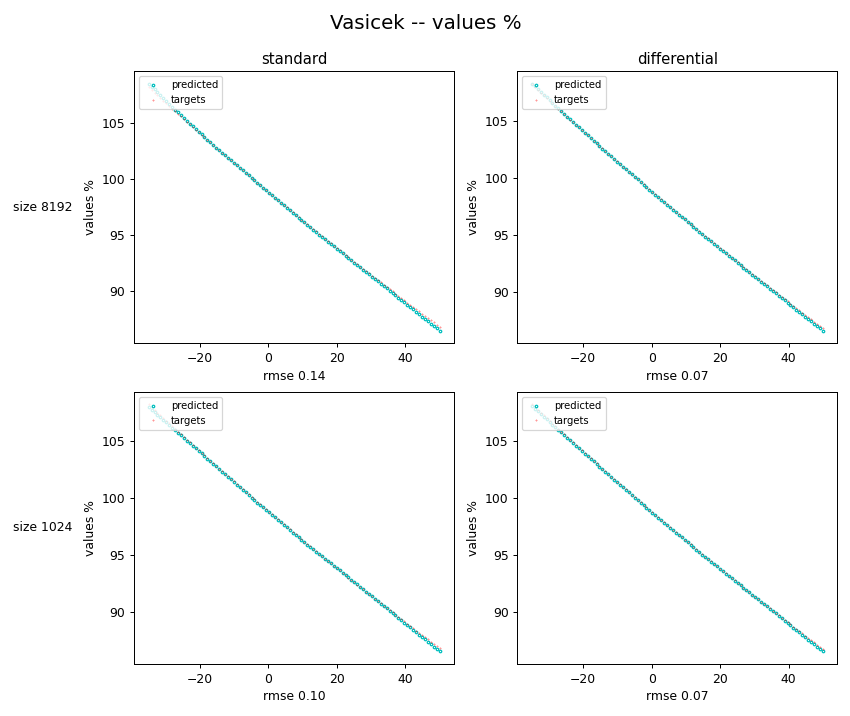

<IPython.core.display.Javascript object>


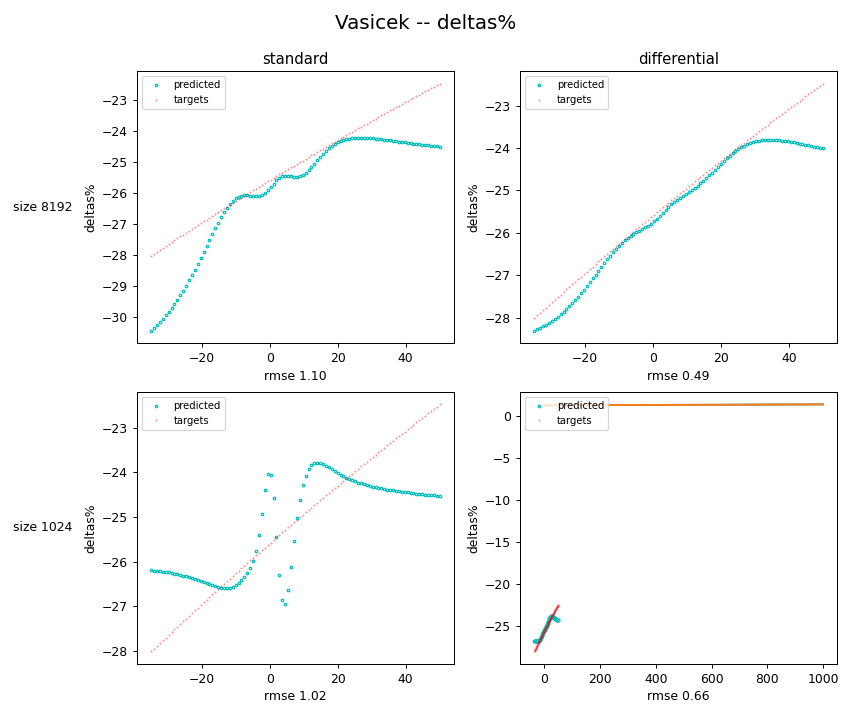

In [19]:
# simulation set sizes to perform
# sizes = [1024, 8192, 65536]
sizes = [8192,1024]
# show delta?
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 100    

# go domestic bond
generator_dom = VasicekBond(domestics_bond,contract)
xAxis_dom, yTest_dom, dydxTest_dom, values_dom, deltas_dom,time_dom = \
    test(generator_dom, sizes, nTest, simulSeed, None, weightSeed)

# go foreign bond
generator_f = VasicekBond(foreign_bond,contract)
xAxis_f, yTest_f, dydxTest_f, values_f, deltas_f,time_f = \
    test(generator_f, sizes, nTest, simulSeed, None, weightSeed)

# show predicitions
graph("Vasicek", values_dom, xAxis_dom, "", "values %", yTest_dom, sizes, True)

# show deltas
if showDeltas:
    graph("Vasicek", deltas_dom, xAxis_dom, "", "deltas%", dydxTest_dom, sizes, True)

## 6. Pricing Methods Comparison

In [21]:
start = time.time()
(r_es_d, bondprice_es_d) = pricer_bond_vasicek_explicitFD(contract,domestics_bond,fd_dom)
(r_es_f, bondprice_es_f) = pricer_bond_vasicek_explicitFD(contract,foreign_bond,fd_for)
end = time.time()

exp_fd_time=round(end - start,2)

start = time.time()
(r_cn_d, bondprice_cn_d) = pricer_bond_vasicek_CrankNicolson(contract,domestics_bond,fd_dom2)
(r_cn_f, bondprice_cn_f) = pricer_bond_vasicek_CrankNicolson(contract,foreign_bond,fd_for2)
end = time.time()

cn_fd_time=round(end - start,2)

start = time.time()
num_prices=100
r_mc = np.linspace(fd_dom.rMin,fd_dom.rMax, num_prices)
bondprice_mc_d=[]
bondprice_mc_f=[]
for r_ in r_mc:
    domestics_bond.r0 = r_
    foreign_bond.r0 = r_
    bondprice_mc_d.append(pricer_bond_vasicek_MonteCarlo(domestics_bond,contract))
    bondprice_mc_f.append(pricer_bond_vasicek_MonteCarlo(foreign_bond,contract))
end = time.time()

mc_time=round(end - start,2)

In [33]:
N=1000
X0 = 1.3
s=8192

r_d = np.linspace(0.02,0.2, N)
r_f = np.linspace(0.2,0.02, N)
forward_fx_cn = np.zeros(N)
forward_fx_es = np.zeros(N)
forward_fx_mc = np.zeros(N)
forward_fx_snn = np.zeros(N)
forward_fx_dml = np.zeros(N)
forward_fx_analytical = np.zeros(N)

# tak test
test_bond_cn_f = np.zeros(N)
test_bond_cn_d = np.zeros(N)
test_bond_dml_f = np.zeros(N)
test_bond_dml_d = np.zeros(N)

bondprice_dml_d=[ p[0] for p in values_dom[("differential", s)].tolist()]
bondprice_dml_f=[ p[0] for p in values_f[("differential", s)].tolist()]
bondprice_snn_d=[ p[0] for p in values_dom[("standard", s)].tolist()]
bondprice_snn_f=[ p[0] for p in values_f[("standard", s)].tolist()]

# Loops to be able to time the time it takes to solve via the finite-difference methods, Crank-Nicolson, MC and Analytical

for i, r_ in enumerate(tqdm(r_d)):
    foreign_bond.r0 = r_f[i]
    domestics_bond.r0 = r_
    
    bond_cn_f = interpolate_rate(r_cn_f,bondprice_cn_f,r_f[i])
    bond_cn_d = interpolate_rate(r_cn_d,bondprice_cn_d,r_)
    
    bond_es_f = interpolate_rate(r_es_f,bondprice_es_f,r_f[i])
    bond_es_d = interpolate_rate(r_es_d,bondprice_es_d,r_)
    
    bond_mc_f = interpolate_rate(r_mc,bondprice_mc_f,r_f[i])
    bond_mc_d = interpolate_rate(r_mc,bondprice_mc_d,r_)
    
    bond_snn_f = interpolate_rate(xAxis_f,bondprice_snn_f,r_f[i])
    bond_snn_d = interpolate_rate(xAxis_dom,bondprice_snn_d,r_)
    
    bond_dml_f = interpolate_rate(xAxis_f,bondprice_dml_f,r_f[i])
    bond_dml_d = interpolate_rate(xAxis_dom,bondprice_dml_d,r_)
    
    # tak test
    test_bond_cn_f[i]  = bond_cn_f
    test_bond_cn_d[i]  = bond_cn_d
    test_bond_dml_f[i] = bond_dml_f
    test_bond_dml_d[i] = bond_dml_d
    
    forward_fx_cn[i] = price_forward_fx(X0,bond_cn_f, bond_cn_d)
    forward_fx_es[i] = price_forward_fx(X0, bond_es_f, bond_es_d)
    forward_fx_mc[i] = price_forward_fx(X0, bond_mc_f, bond_mc_d)
    forward_fx_snn[i]= price_forward_fx(X0, bond_snn_f, bond_snn_d)
    forward_fx_dml[i]= price_forward_fx(X0, bond_dml_f, bond_dml_d)
    forward_fx_analytical[i] = forward_exchange_rate(X0, foreign_bond, domestics_bond, contract)
    

100%|██████████| 1000/1000 [00:00<00:00, 1472.20it/s]


# Tak Test

In [101]:
# tak test
test_bond = Dynamics()
test_bond.r0 = 0.02
test_bond.theta = 2.0
test_bond.mu = 0.05
test_bond.sigma = 0.08
#test_bond.r0 = 0.04
#test_bond.theta = 3
#test_bond.mu = 0.05
#test_bond.sigma = 0.08

test_contract = Contract()
test_contract.T = 5.0

test_fd = FD()
test_fd.rMax=0.35
test_fd.rMin=-0.1
test_fd.deltat=contract.T/10000
test_fd.deltar=test_bond.sigma*np.sqrt(test_fd.deltat) 

res_vasicek = stoc_bond_price(test_bond,test_contract)
res_cn = pricer_bond_vasicek_CrankNicolson(test_contract,test_bond,test_fd)


In [102]:
interpolate_rate(res_cn[0],res_cn[1],test_bond.r0)

array(0.79325613)

In [103]:
res_vasicek

0.7932628537997579

<IPython.core.display.Javascript object>


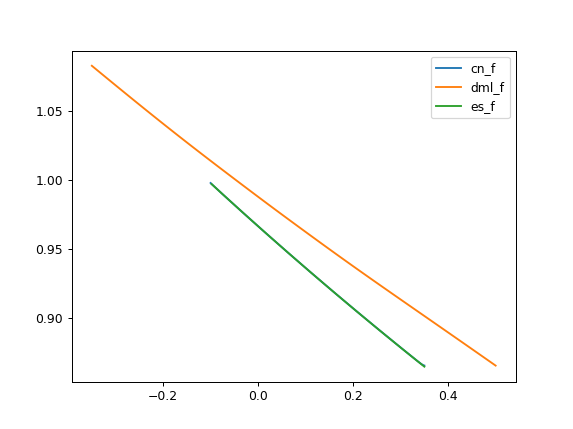

In [81]:
#test = stoc_bond_price(generator_dom.dynamics,generator_dom.contract)

plt.figure()
#plt.plot(r_d,test_bond_cn_f)
#plt.plot(r_d,test_bond_dml_f)
plt.plot(r_cn_d,bondprice_cn_d,label='cn_f')
plt.plot(xAxis_dom,bondprice_dml_d,label='dml_f')
plt.plot(r_es_d,bondprice_es_d,label='es_f')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


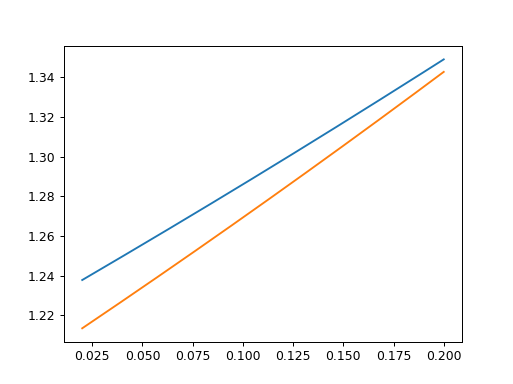

In [32]:
plt.figure()
plt.plot(r_d,forward_fx_dml)
plt.plot(r_d,forward_fx_cn)
plt.show()

<IPython.core.display.Javascript object>


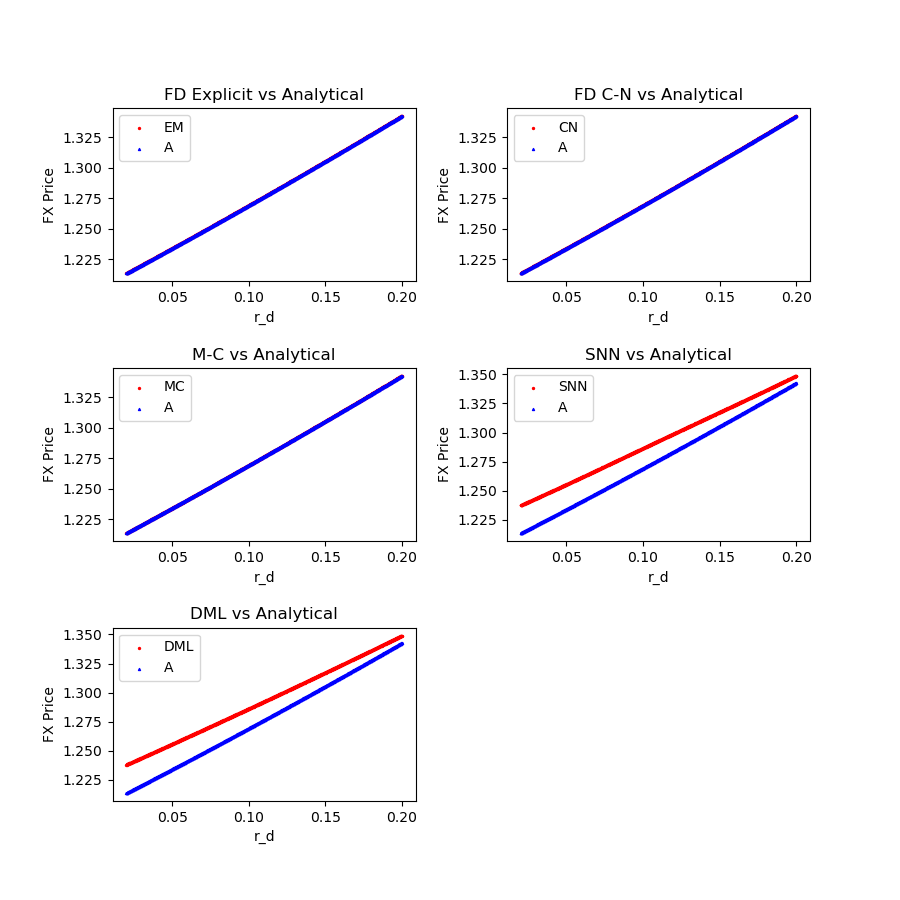

In [27]:
fig = plt.figure(figsize = (9,9))
X = r_d
Y = r_f
Z1 = forward_fx_es
Z2 = forward_fx_cn
Z3 = forward_fx_mc
Z4 = forward_fx_snn
Z5 = forward_fx_dml
Z6 = forward_fx_analytical

ax1 = fig.add_subplot(321)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z1), ('b','^', Z6)]:
    ax1.scatter(X, Z, c = c, marker = m,s=2)
    
ax1.legend(["EM","A"],loc="upper left")
ax1.set_xlabel('r_d')
ax1.set_ylabel('FX Price')
ax1.title.set_text('FD Explicit vs Analytical')

ax2 = fig.add_subplot(322)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z2), ('b','^', Z6)]:
    ax2.scatter(X, Z, c = c, marker = m,s=2)
    
ax2.legend(["CN","A"],loc="upper left")
ax2.set_xlabel('r_d')
ax2.set_ylabel('FX Price')
ax2.title.set_text('FD C-N vs Analytical')

ax3 = fig.add_subplot(323)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z3), ('b','^', Z6)]:
    ax3.scatter(X, Z, c = c, marker = m,s=2)
    
ax3.legend(["MC","A"],loc="upper left")
ax3.set_xlabel('r_d')
ax3.set_ylabel('FX Price')
ax3.title.set_text('M-C vs Analytical')


ax4 = fig.add_subplot(324)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z4), ('b','^', Z6)]:
    ax4.scatter(X, Z, c = c, marker = m,s=2)

ax4.legend(["SNN","A"],loc="upper left")
ax4.set_xlabel('r_d')
ax4.set_ylabel('FX Price')
ax4.title.set_text('SNN vs Analytical')


ax5 = fig.add_subplot(325)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z5), ('b','^', Z6)]:
    ax5.scatter(X, Z, c = c, marker = m,s=2)
    
ax5.legend(["DML","A"],loc="upper left")
ax5.set_xlabel('r_d')
ax5.set_ylabel('FX Price')
ax5.title.set_text('DML vs Analytical')

plt.show()

In [28]:
def calc_rmse(exact,est):
    rmse=np.sqrt(((exact-est)**2).mean(axis=0))
    return rmse

In [29]:
txt="{time:.2f} seconds"
txt2="{error:.4f}%"

display(pd.DataFrame(data=[[txt.format(time = exp_fd_time),
                            txt2.format(error=calc_rmse(forward_fx_analytical,forward_fx_es)*100)],
                           [txt.format(time = cn_fd_time),
                            txt2.format(error=calc_rmse(forward_fx_analytical,forward_fx_cn)*100)],
                           [txt.format(time = mc_time),
                           txt2.format(error =calc_rmse(forward_fx_analytical,forward_fx_mc)*100)],
                           [txt.format(time = time_dom[("standard", s)]+time_f[("standard", s)]),
                           txt2.format(error =calc_rmse(forward_fx_analytical,forward_fx_snn)*100)],
                           [txt.format(time = time_dom[("differential", s)]+time_f[("differential", s)]),
                           txt2.format(error =calc_rmse(forward_fx_analytical,forward_fx_dml)*100)]],
                     index=["FD Explicit",
                            "FD Crank-Nicolson",
                            "Monte-Carlo",
                            "Std NN (n={})".format(s),
                            "Diff NN (n={})".format(s)],
                     columns=["Execution Time", "RMSE"]))

,Execution Time,RMSE
FD Explicit,0.60 seconds,0.0002%
FD Crank-Nicolson,3.33 seconds,0.0025%
Monte-Carlo,64.51 seconds,0.0162%
Std NN (n=8192),3.40 seconds,1.6578%
Diff NN (n=8192),4.46 seconds,1.6510%
